# Getting started


In this notebook, we show how to use seqme to evaluate biological sequences and add your own metric. We introduce seqme's functionality through toy examples. Other tutorials show real-world use cases.

First the imports.


In [ ]:
from pprint import pprint
from typing import Literal

import numpy as np

import seqme as sm

## Basics


Let's define the sequences to use and the metrics to compute. Some sequences will be loaded from fasta files, others are hard-coded.


First let's write a fasta file with random sequences to disk.


In [ ]:
RANDOM_SEQUENCES_PATH = "./data/random.fasta"

In [ ]:
random_sequences = ["KKKKK", "PLQ", "RKSPL"]

sm.to_fasta(random_sequences, RANDOM_SEQUENCES_PATH)

UniProt contains a lot of sequences. To speed-up the metric computations, we will only use a (random) subset of the UniProt sequences.


In [ ]:
sequences = {
    "Random": sm.read_fasta(RANDOM_SEQUENCES_PATH),
    "UniProt": sm.random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
    "HydrAMP": ["MMRK", "RKSPL", "RRLSK", "RRLSK"],
    "hyformer": ["MKQW", "RKSPL"],
}

Metrics may precompute some values upon metric object creation to speed up the overall process.


In [ ]:
def hit_rate_condition_fn(sequences: list[str]) -> np.ndarray:
    no_lysine = ~np.array(["K" in seq for seq in sequences])
    return no_lysine


def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts], dtype=float).T


metrics = [
    sm.metrics.Uniqueness(),
    sm.metrics.Novelty(reference=sequences["UniProt"], name="Novelty (UniProt)"),
    sm.metrics.Diversity(),
    sm.metrics.FBD(reference=sequences["Random"], embedder=my_embedder),
    sm.metrics.ID(sm.models.Gravy(), name="Gravy", objective="minimize"),
    sm.metrics.HitRate(condition_fn=hit_rate_condition_fn),
]

Let's compute the metrics.


In [ ]:
df = sm.evaluate(sequences, metrics)

 38%|███▊      | 9/24 [00:00<00:00, 303.68it/s, data=UniProt, metric=FBD]              /Users/rasmus.larsen/work/hackathon-2025/seqme/src/seqme/metrics/fbd.py:92: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, err = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
100%|██████████| 24/24 [00:00<00:00, 469.42it/s, data=hyformer, metric=Hit-rate]         


Let's look at the results.


In [ ]:
df

Uniqueness           Novelty (UniProt)           Diversity            \
              value deviation             value deviation     value deviation   
Random         1.00       NaN               1.0       NaN  0.866667       NaN   
UniProt        1.00       NaN               0.0       NaN  1.000000       NaN   
HydrAMP        0.75       NaN               1.0       NaN  0.700000       NaN   
hyformer       1.00       NaN               1.0       NaN  0.800000       NaN   

               FBD               Gravy            Hit-rate            
             value deviation     value deviation     value deviation  
Random    0.000000       NaN -1.911111  1.460678  0.333333       NaN  
UniProt   3.961130       NaN -2.400000  0.650000  0.500000       NaN  
HydrAMP   8.602244       NaN -1.627500  0.363413  0.000000       NaN  
hyformer  8.228118       NaN -1.500000  0.100000  0.000000       NaN

... let's make it nicer to look at.


In [ ]:
sm.show(df, n_decimals=3)

,Uniqueness↑,Novelty (UniProt)↑,Diversity↑,FBD↓,Gravy↓,Hit-rate↑
Random,1.000,1.000,0.867,0.000,-1.911±1.461,0.333
UniProt,1.000,0.000,1.000,3.961,-2.400±0.650,0.500
HydrAMP,0.750,1.000,0.700,8.602,-1.628±0.363,0.000
hyformer,1.000,1.000,0.800,8.228,-1.500±0.100,0.000


Let's also do a parallel coordinates plot.


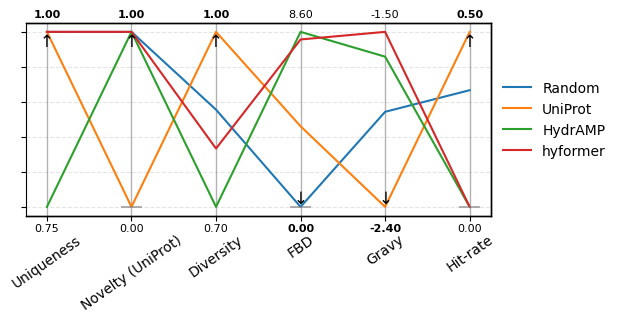

In [ ]:
sm.parallel_coordinates(df, arrow_size=12, x_ticks_fontsize=10, x_ticks_rotation=35, figsize=(6, 2.5), show_arrow=False)

We are particularly interested in the following metric.


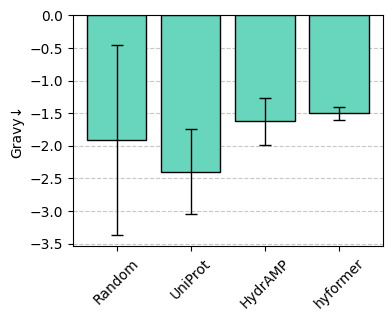

In [ ]:
sm.barplot(df, "Gravy")

Let's extract the two rows with lowest Gravy.


In [ ]:
sm.show(sm.top_k(df, "Gravy", k=2))

,Uniqueness↑,Novelty (UniProt)↑,Diversity↑,FBD↓,Gravy↓,Hit-rate↑
Random,1.00,1.00,0.87,0.00,-1.91±1.46,0.33
UniProt,1.00,0.00,1.00,3.96,-2.40±0.65,0.50


To write a metric dataframe to disk, encode the dataframe as a pickle object.


In [ ]:
PATH = "./metrics_dataframe.pkl"

sm.to_pickle(df, PATH)
sm.show(sm.read_pickle(PATH), color_style="gradient")

,Uniqueness↑,Novelty (UniProt)↑,Diversity↑,FBD↓,Gravy↓,Hit-rate↑
Random,1.00,1.00,0.87,0.00,-1.91±1.46,0.33
UniProt,1.00,0.00,1.00,3.96,-2.40±0.65,0.50
HydrAMP,0.75,1.00,0.70,8.60,-1.63±0.36,0.00
hyformer,1.00,1.00,0.80,8.23,-1.50±0.10,0.00


It is also possible to export the dataframe to a LaTeX table or a PNG as shown below.

To save the styled metric dataframe to a png, we use `dataframe_image`.


In [ ]:
# !pip install dataframe_image

In [ ]:
SAVE_TABLE = True

if SAVE_TABLE:
    # save to LaTeX
    sm.to_latex(df, "table.tex", n_decimals=3, color=None, caption="My first table")

    # save to PNG
    import dataframe_image as dfi

    styler = sm.show(df, n_decimals=3, color_style="bar")
    await dfi.export_async(styler, "table.png", dpi=300)

That it all for the basic usage of seqme. Check out the documentation for the [metrics](https://seqme.readthedocs.io/en/stable/api/metrics_index.html) and [models](https://seqme.readthedocs.io/en/stable/api/models_index.html) implemented in seqme. 

Let's now look at some more advanced features!


## Advanced


In the advanced section, we show how to

- Combine multiple metric dataframes into one.
- Improve performance through caching.
- Create your own metric.


### Combining metric dataframes

seqme's `combine` can combine metric dataframes with different sequences and/or metrics. This can be useful if you want to evaluate the sequences on an additional metric or add an additional set of sequences for evaluation - without needing to recompute the results.


Let's create three metric dataframes.


In [ ]:
df1 = sm.evaluate(
    sequences={
        "s1": ["KKKKK", "PLUQ", "RKSPL"],
        "s2": sm.random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
        "s3": ["MMRK", "RKSPL", "RRLSK"],
        "s4": ["MKQW", "RKSPL"],
    },
    metrics=[
        sm.metrics.Novelty(reference=["KKW", "RKSPL"]),
        sm.metrics.Novelty(reference=["RASD", "KKKQ", "LPTUY"], name="Novelty (Random)"),
    ],
    verbose=False,
)

df2 = sm.evaluate(
    sequences={"s4": ["MKQW", "RKSPL"], "s5": ["MKQW"]},
    metrics=[sm.metrics.ID(sm.models.Gravy(), name="Gravy", objective="minimize")],
    verbose=False,
)

df3 = sm.evaluate(
    sequences={"s6": ["MKQW", "RKSPL"]},
    metrics=[
        sm.metrics.ID(sm.models.Gravy(), name="Gravy", objective="minimize"),
        sm.metrics.Novelty(reference=["KKW", "RKSPL"]),
    ],
    verbose=False,
)

Let's combine the dataframes.


In [ ]:
df = sm.combine([df1, df2, df3])

In [ ]:
df

Novelty           Novelty (Random)           Gravy          
       value deviation            value deviation value deviation
s1  0.666667       NaN              1.0       NaN   NaN       NaN
s2  1.000000       NaN              0.5       NaN   NaN       NaN
s3  0.666667       NaN              1.0       NaN   NaN       NaN
s4  0.500000       NaN              1.0       NaN  -1.5       0.1
s5       NaN       NaN              NaN       NaN  -1.6       NaN
s6  0.500000       NaN              NaN       NaN  -1.5       0.1

... let's make it nicer to look at.


In [ ]:
sm.show(df, n_decimals=[3, 2, 1], color="#d66868")

,Novelty↑,Novelty (Random)↑,Gravy↓
s1,0.667,1.00,-
s2,1.000,0.50,-
s3,0.667,1.00,-
s4,0.500,1.00,-1.5±0.1
s5,-,-,-1.6
s6,0.500,-,-1.5±0.1


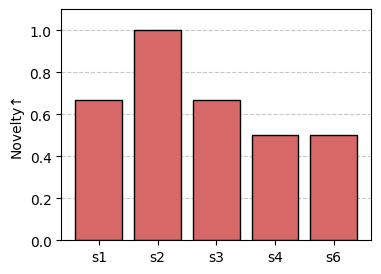

In [ ]:
sm.barplot(df, "Novelty", color="#d66868", ylim=(0.0, 1.1), x_ticks_rotation=0.0)

Notice missing values (e.g., "Novelty" for "s5") are not shown in the barplot.


### Caching

Discriminators and embedders can be computational expensive to execute. To reduce the number of function evaluations for these models, we can cache the results of discriminators and embedders.

The cache works like this: If a (sequence, embedding)-pair is already stored in the cache then retrieve the embedding. Otherwise compute the embedding, store the pair in the cache and retrieve the embedding.

Let's create two toy models and the cache.


In [ ]:
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts], dtype=float).T


def my_discriminator(sequences: list[str]) -> np.ndarray:
    return np.ones(len(sequences)) * 0.85


cache = sm.Cache(models={"embedder": my_embedder, "discriminator": my_discriminator})

Optional: We can manually add model outputs to the cache. This is useful when e.g., (sequence, embedding)-pairs are already pre-computed and stored in a file.


In [ ]:
seqs = ["MKQW", "AA", "BB"]
reps = my_embedder(seqs)

pairs = dict(zip(seqs, reps, strict=True))

cache.add(model_name="embedder", element=pairs)

Let's compute the metrics. Since both the `Precision` and `Recall` metric use the same embedding model (`embedder`), the embedding is only computed once per sequence in `sequences` (instead of twice)!

Notice, we now use `cache.model()` instead of the embedder reference (`my_embedder`) directly.


In [ ]:
df = sm.evaluate(
    sequences={
        "hyformer": ["RMKQW", "RKSPL", "RRRASD"],
        "HydrAMP": ["MKQW", "RKSPLP"],
        "Random": ["AAA", "PPPPP"],
    },
    metrics=[
        sm.metrics.Precision(
            reference=["AKWR", "AKKR", "KKKK"],
            embedder=cache.model("embedder"),
            n_neighbors=1,
            strict=False,
        ),
        sm.metrics.Recall(
            reference=["AKWR", "AKKR", "KKKK"],
            embedder=cache.model("embedder"),
            n_neighbors=1,
            strict=False,
        ),
    ],
)

sm.show(df, color="#69bce8")

100%|██████████| 6/6 [00:00<00:00, 357.80it/s, data=Random, metric=Recall]    


,Precision↑,Recall↑
hyformer,0.67,0.00
HydrAMP,0.50,0.67
Random,0.00,0.33


Let's write the cached (sequence, embedding)-pairs for each model to a file and reinitialize the cache.


In [ ]:
PATH = "precomputed.pkl"

sm.to_pickle(cache.get(), PATH)

precomputed = sm.read_pickle(PATH)

cache = sm.Cache(init_cache=precomputed)
pprint(cache.get())

{'discriminator': {},
 'embedder': {'AA': array([2., 0.]),
              'AAA': array([3., 0.]),
              'AKKR': array([4., 2.]),
              'AKWR': array([4., 1.]),
              'BB': array([2., 0.]),
              'KKKK': array([4., 4.]),
              'MKQW': array([4., 1.]),
              'PPPPP': array([5., 0.]),
              'RKSPL': array([5., 1.]),
              'RKSPLP': array([6., 1.]),
              'RMKQW': array([5., 1.]),
              'RRRASD': array([6., 0.])}}


**Tip:**
The cache can become very useful if you use an external tool to predict sequence properties, e.g., a command-line tool or a tool implemented in another programming language. Now you want to use these predictions in seqme to a compute metric. To do so, 1. read the predictions stored in a file and 2. pre-init the `Cache` with these (sequence, predictions)-pairs.


### Creating a new metric


You can also integrate your own metrics into seqme through the `Metric` interface as shown below.


In [ ]:
class MyMetric(sm.Metric):
    def __init__(self, amino_acid: str, minimize: bool = True):
        self.amino_acid = amino_acid
        self.minimize = minimize

    def __call__(self, sequences: list[str]) -> sm.MetricResult:
        aa_count = sum([seq.count(self.amino_acid) for seq in sequences])
        aa_total = sum([len(sequence) for sequence in sequences])
        return sm.MetricResult(aa_count / aa_total)

    @property
    def name(self) -> str:
        return f"{self.amino_acid}-frequency"

    @property
    def objective(self) -> Literal["minimize", "maximize"]:
        return "minimize" if self.minimize else "maximize"

Let's use our new metric.


In [ ]:
df = sm.evaluate(
    sequences={
        "hyformer": ["MKQW", "RKSPL", "RASD"],
        "HydrAMP": ["MKQW", "RKSPL"],
        "Random": ["AAAA", "PPPPP"],
    },
    metrics=[
        MyMetric(amino_acid="K", minimize=False),
        MyMetric(amino_acid="R", minimize=True),
    ],
)

sm.show(df, color="#e07fe1", color_style="bar", caption="Table 1. Our first metric 🎉")

100%|██████████| 6/6 [00:00<00:00, 2187.38it/s, data=Random, metric=R-frequency]  


,K-frequency↑,R-frequency↓
hyformer,0.15,0.15
HydrAMP,0.22,0.11
Random,0.00,0.00


We have now covered the main functionality of seqme! 🎉

seqme also contains functionality to add third-party models, evaluate embedding models alignment with the property/properties of interest and a few extra things.
